<a href="https://colab.research.google.com/github/rafiulislamri/Deep-CNN-weather_forecast_Bangladesh_v1.0-Transformer-Model------Training-07/blob/main/weather_forecast_Bangladesh_v1_0(Transformer_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WEATHER FORECASTING FOR BANGLADESH – Deep Learning Project
# Dataset: Uploaded manually
# Target: Next-day Rainfall (mm) and/or Max Temperature (°C)
# Model: Transformer / attention-based sequence model

In [2]:
# Install dependencies
!pip install tensorflow -q

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
# import tensorflow_addons as tfa # Removed deprecated library
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
from google.colab import files
print("📂 Please upload your dataset CSV file(s)")
uploaded = files.upload()  # this opens a file picker

dataframes = []
for filename in uploaded.keys():
    print(f"✅ File uploaded: {filename}")
    try:
        df = pd.read_csv(filename)
        dataframes.append(df)
        print(f"🧾 Loaded {filename} with shape:", df.shape)
        print(df.head())
    except Exception as e:
        print(f"❌ Error loading {filename}: {e}")

if dataframes:
    print(f"\nLoaded {len(dataframes)} DataFrame(s).")
else:
    print("\n⚠️ No DataFrames were loaded.")

📂 Please upload your dataset CSV file(s)


Saving BD_weather.csv to BD_weather (1).csv
✅ File uploaded: BD_weather (1).csv
🧾 Loaded BD_weather (1).csv with shape: (543839, 8)
      Station  Year  Month  Day  Rainfall  Sunshine  Humidity  Temperature
0  Ambaganctg  2008      1    1       0.0       9.1      78.0         20.1
1  Ambaganctg  2008      1    2       0.0       5.6      79.0         21.0
2  Ambaganctg  2008      1    3       0.0       8.6      82.0         20.1
3  Ambaganctg  2008      1    4       0.0       9.1      73.0         21.0
4  Ambaganctg  2008      1    5       0.0       9.4      67.0         20.3

Loaded 1 DataFrame(s).


In [8]:
# Try to identify a column that looks like a date
possible_date_cols = [c for c in df.columns if 'date' in c.lower()]
if possible_date_cols:
    df[possible_date_cols[0]] = pd.to_datetime(df[possible_date_cols[0]])
    df = df.sort_values(by=possible_date_cols[0])
else:
    print("⚠️ No explicit date column detected; assuming dataset already ordered by time.")

# Check for station column
station_col = None
for c in df.columns:
    if 'station' in c.lower() or 'id' in c.lower():
        station_col = c
        break

if station_col:
    print(f"🛰 Using station column: {station_col}")
    # Choose one station for demonstration (first one)
    first_station = df[station_col].unique()[0]
    df_station = df[df[station_col] == first_station].copy()
    print(f"✅ Selected station: {first_station}")
else:
    print("⚠️ No station column found — assuming data is already combined.")
    df_station = df.copy()

# Define which columns to use
feature_candidates = [
    'temp_min', 'temp_max', 'humidity', 'wind_speed',
    'sunshine', 'rainfall', 'rainfall_mm', 'rain', 'Temperature', 'Rainfall', 'Humidity', 'Sunshine'
]

# Try to auto-detect available features
feature_cols = [c for c in feature_candidates if c in df_station.columns]
print("🧩 Using feature columns:", feature_cols)

# Create target variables: next-day rainfall & next-day max temp
target_rain = None
for name in ['Rainfall', 'rainfall_mm', 'rainfall', 'rain']:
    if name in df_station.columns:
        target_rain = name
        break

target_temp = None
for name in ['Temperature', 'temp_max', 'maximum_temperature', 'tmax']:
    if name in df_station.columns:
        target_temp = name
        break

if not target_rain or not target_temp:
    raise ValueError("🚫 Could not detect rainfall or temperature column names automatically. Please rename columns appropriately.")

df_station['rain_next_day'] = df_station[target_rain].shift(-1)
df_station['temp_max_next_day'] = df_station[target_temp].shift(-1)
df_station = df_station.dropna(subset=['rain_next_day', 'temp_max_next_day'])

# Select data
X_data = df_station[feature_cols]
y_data = df_station[['rain_next_day', 'temp_max_next_day']]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

⚠️ No explicit date column detected; assuming dataset already ordered by time.
🛰 Using station column: Station
✅ Selected station: Ambaganctg
🧩 Using feature columns: ['Temperature', 'Rainfall', 'Humidity', 'Sunshine']


In [9]:
SEQ_LEN = 7
X_seq, y_seq = [], []

for i in range(len(X_scaled) - SEQ_LEN):
    X_seq.append(X_scaled[i:i+SEQ_LEN, :])
    y_seq.append(y_data.values[i+SEQ_LEN, :])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

print("✅ Sequence shapes -> X:", X_seq.shape, ", y:", y_seq.shape)

# Split train/test
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
print("Train:", X_train.shape, "Test:", X_test.shape)

✅ Sequence shapes -> X: (5836, 7, 4) , y: (5836, 2)
Train: (4668, 7, 4) Test: (1168, 7, 4)


In [10]:
# Build Transformer-based model

def build_transformer(seq_len, n_features, n_targets):
    inp = tf.keras.layers.Input(shape=(seq_len, n_features))
    x = tf.keras.layers.Dense(64, activation='relu')(inp)
    x = tf.keras.layers.LayerNormalization()(x)
    attn = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = tf.keras.layers.Add()([x, attn])
    x = tf.keras.layers.LayerNormalization()(x)
    ff = tf.keras.layers.Dense(128, activation='relu')(x)
    ff = tf.keras.layers.Dense(64, activation='relu')(ff)
    pooled = tf.keras.layers.GlobalAveragePooling1D()(ff)
    out = tf.keras.layers.Dense(n_targets)(pooled)
    model = tf.keras.Model(inputs=inp, outputs=out)
    return model

model = build_transformer(SEQ_LEN, X_train.shape[2], y_train.shape[1])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 7, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 7, 64)     │        320 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 7, 64)     │        128 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 64)     │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 7, 64)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 7, 64)     │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7, 128)    │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7, 64)     │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ dense_2[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 83,650 (326.76 KB)

 Trainable params: 83,650 (326.76 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# train model

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=40,
    batch_size=32,
    verbose=1
)

Epoch 1/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 312.8056 - mae: 5.5708 - val_loss: 244.5110 - val_mae: 6.5507
Epoch 2/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 237.0484 - mae: 5.5881 - val_loss: 323.0652 - val_mae: 8.0707
Epoch 3/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 193.7601 - mae: 5.2148 - val_loss: 269.3360 - val_mae: 7.1658
Epoch 4/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 267.0585 - mae: 5.9304 - val_loss: 247.8278 - val_mae: 6.0407
Epoch 5/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 313.2584 - mae: 6.0273 - val_loss: 257.1389 - val_mae: 6.5676
Epoch 6/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 220.3834 - mae: 5.5454 - val_loss: 235.4049 - val_mae: 6.4127
Epoch 7/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 203.2615 - mae: 5.3409 - val_loss: 381.4302 - val_mae: 8.6728
Epoch 8/40
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 234.9247 - mae: 5.6952 - val_loss: 272.1235 - val_mae: 7.0837
Epoch 9/40
117/1

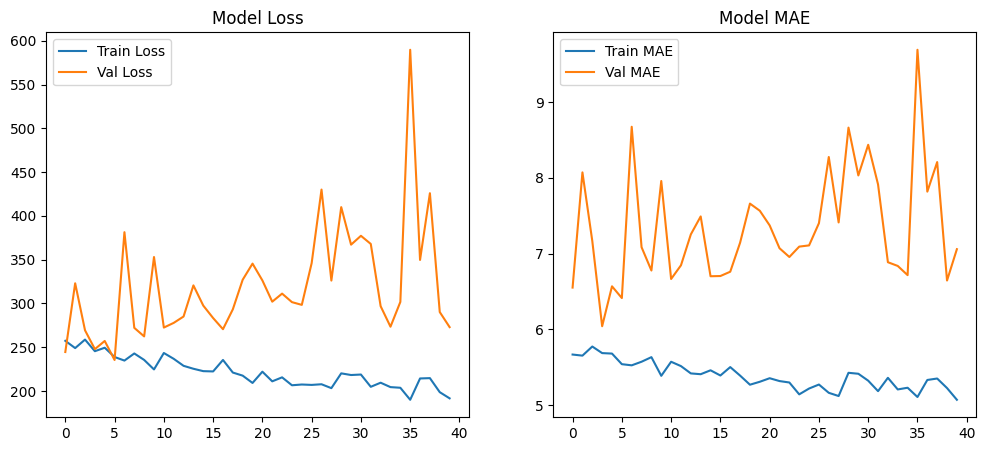

In [14]:
# Visualize Training Performance

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Model Loss')

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend(); plt.title('Model MAE')
plt.show()

In [15]:
# Evaluate on Test Data

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"📊 Test MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
📊 Test MSE: 298.8766 | MAE: 5.9222 | R²: 0.3415


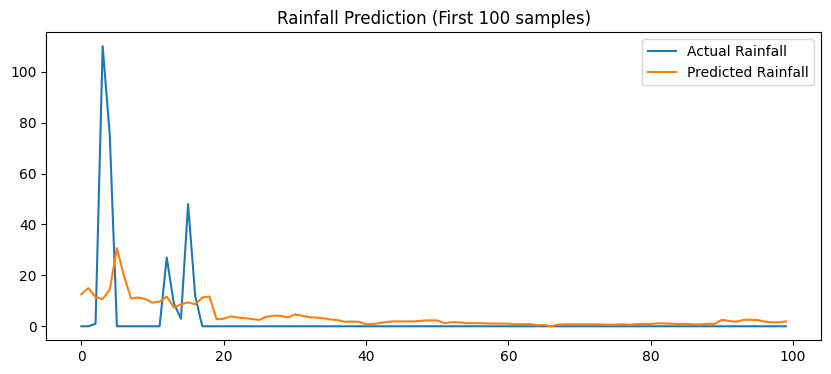

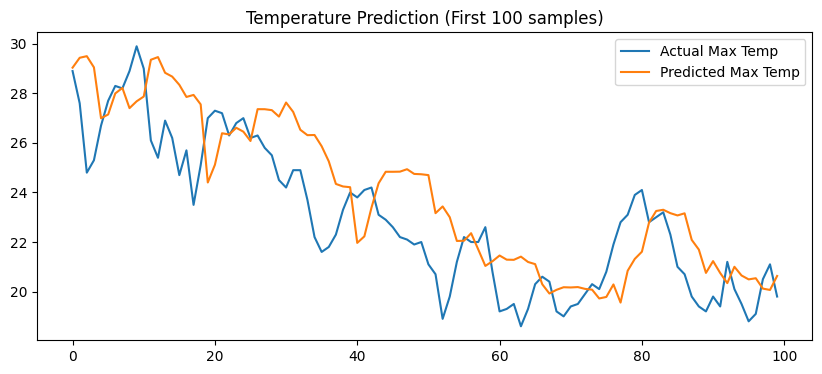

In [16]:
# Visualize Predictions

plt.figure(figsize=(10,4))
plt.plot(y_test[:100,0], label='Actual Rainfall')
plt.plot(y_pred[:100,0], label='Predicted Rainfall')
plt.title('Rainfall Prediction (First 100 samples)')
plt.legend(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(y_test[:100,1], label='Actual Max Temp')
plt.plot(y_pred[:100,1], label='Predicted Max Temp')
plt.title('Temperature Prediction (First 100 samples)')
plt.legend(); plt.show()

In [17]:
model.save('Bangladesh_Weather_Transformer.h5')
print("✅ Model saved as 'Bangladesh_Weather_Transformer.h5'")

✅ Model saved as 'Bangladesh_Weather_Transformer.h5'


To predict today's temperature for Dhaka, we would need:

1.  A dataset containing weather data specifically for Dhaka.
2.  The model is currently trained to predict the *next day's* weather. To predict *today's* temperature, you would need to provide the model with the sequence of weather data leading up to yesterday.
3.  Access to recent historical weather data for Dhaka to form the input sequence for the prediction.

Since the current dataset is for 'Ambaganctg' and doesn't include real-time data for Dhaka, we cannot make that specific prediction with the existing setup.

In [18]:
# Function to get the last SEQ_LEN days of data for prediction
def get_last_sequence_data(dataframe, seq_len, feature_cols):
    # Ensure the dataframe has enough data for the sequence length
    if len(dataframe) < seq_len:
        raise ValueError(f"Not enough data for a sequence of length {seq_len}. Need at least {seq_len} days of data.")

    # Get the last 'seq_len' rows
    last_sequence_df = dataframe[feature_cols].tail(seq_len)

    return last_sequence_df

# Get the last SEQ_LEN days of data from the original dataframe (before sequence creation)
# We use df_station here because it contains the original feature columns before sequencing
last_sequence_data = get_last_sequence_data(df_station, SEQ_LEN, feature_cols)

# Scale the data using the same scaler fitted on the training data
last_sequence_scaled = scaler.transform(last_sequence_data)

# Reshape the scaled data to match the model's input shape (1, SEQ_LEN, n_features)
last_sequence_reshaped = last_sequence_scaled.reshape(1, SEQ_LEN, len(feature_cols))

# Make the prediction
predicted_values = model.predict(last_sequence_reshaped)

# The predicted values are in the scaled format. If your target variables were scaled,
# you would need to inverse transform them here.
# However, in this notebook, y_data was not explicitly scaled, only X_data.
# So, the predictions are likely in the original units of Rainfall and Temperature.

# Display the prediction
print("\n🔮 Predicted weather for tomorrow:")
print(f"  Rainfall: {predicted_values[0][0]:.4f} mm")
print(f"  Maximum Temperature: {predicted_values[0][1]:.4f} °C")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

🔮 Predicted weather for tomorrow:
  Rainfall: 1.4422 mm
  Maximum Temperature: 23.1143 °C
